In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os, shutil, random, pickle
import cv2
import keras
from sklearn.metrics import confusion_matrix
from keras import models
from keras import layers
from keras import regularizers
from keras import initializers
from keras import activations
from keras import callbacks
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()

print("TensorFlow version: " + tf.__version__)
print("Keras version: " + keras.__version__)
print("Detected GPUs: " + str(tf.config.experimental.list_physical_devices('GPU')))
print("Detected CPUs: " + str(tf.config.experimental.list_physical_devices('CPU')))

TensorFlow version: 2.10.1
Keras version: 2.10.0
Detected GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Detected CPUs: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


### Configuration

In [45]:
batch_size = 64  # size of the batch
epochs = 5  # model epochs
img_rows = 32  # height of the input images
img_cols = 32  # width of the input images
output_size = 43  # number of classes (size of the one hot vector)

### Load & preprocess data

In [3]:
home = 'E:/OneDrive - Akademia Górniczo-Hutnicza im. Stanisława Staszica w Krakowie/Programming/Data/tsd'
models_dir = 'E:/OneDrive - Akademia Górniczo-Hutnicza im. Stanisława Staszica w Krakowie/Programming/Data/tsd/model'
model_name = 'tsd_class_v13.h5'
data_dir = "data_preprocessed.pickle"

In [4]:
# raw data & variables
data = pd.read_pickle(os.path.join(home, data_dir))

x_train = data['x_train']
y_train = data['y_train']

x_test = data['x_test']
y_test = data['y_test']

x_valid = data['x_validation']
y_valid = data['y_validation']

labels = data['labels']

### Data visualization

In [5]:
def decode_one_hot(one_hot):
    return np.where(one_hot == 1)[0][0]

In [6]:
def percentage_one_hot(one_hot):
    return round(one_hot*100, 2)

In [7]:
def show_class_example(x_data, y_data, labels, c):
    assert len(x_data) == len(y_data)
    
    f,ax = plt.subplots(1, 2)
    f.set_size_inches(10, 5)
    f_index = 0
    
    while True:
        index = random.randint(0, len(y_data))
        if decode_one_hot(y_data[index]) == c[f_index]:
            ax[f_index].set_title(labels[c[f_index]])
            ax[f_index].imshow(x_data[index])
            f_index += 1
        
        if f_index == 2:
            break

In [8]:
def show_sample(shape, x_data, y_data, labels):
    assert shape[0] > 1 and shape[1] >1
    assert len(x_data) == len(y_data)
    
    height = 4*shape[0]
    width = 4*shape[1]
    
    f, ax = plt.subplots(shape[0], shape[1])
    f.set_size_inches(width, height)
    for y in range(shape[0]):
        for x in range(shape[1]):
            index = random.randint(0, len(x_data))
            ax[y][x].set_title(labels[decode_one_hot(y_data[index])])
            ax[y][x].imshow(x_data[index])

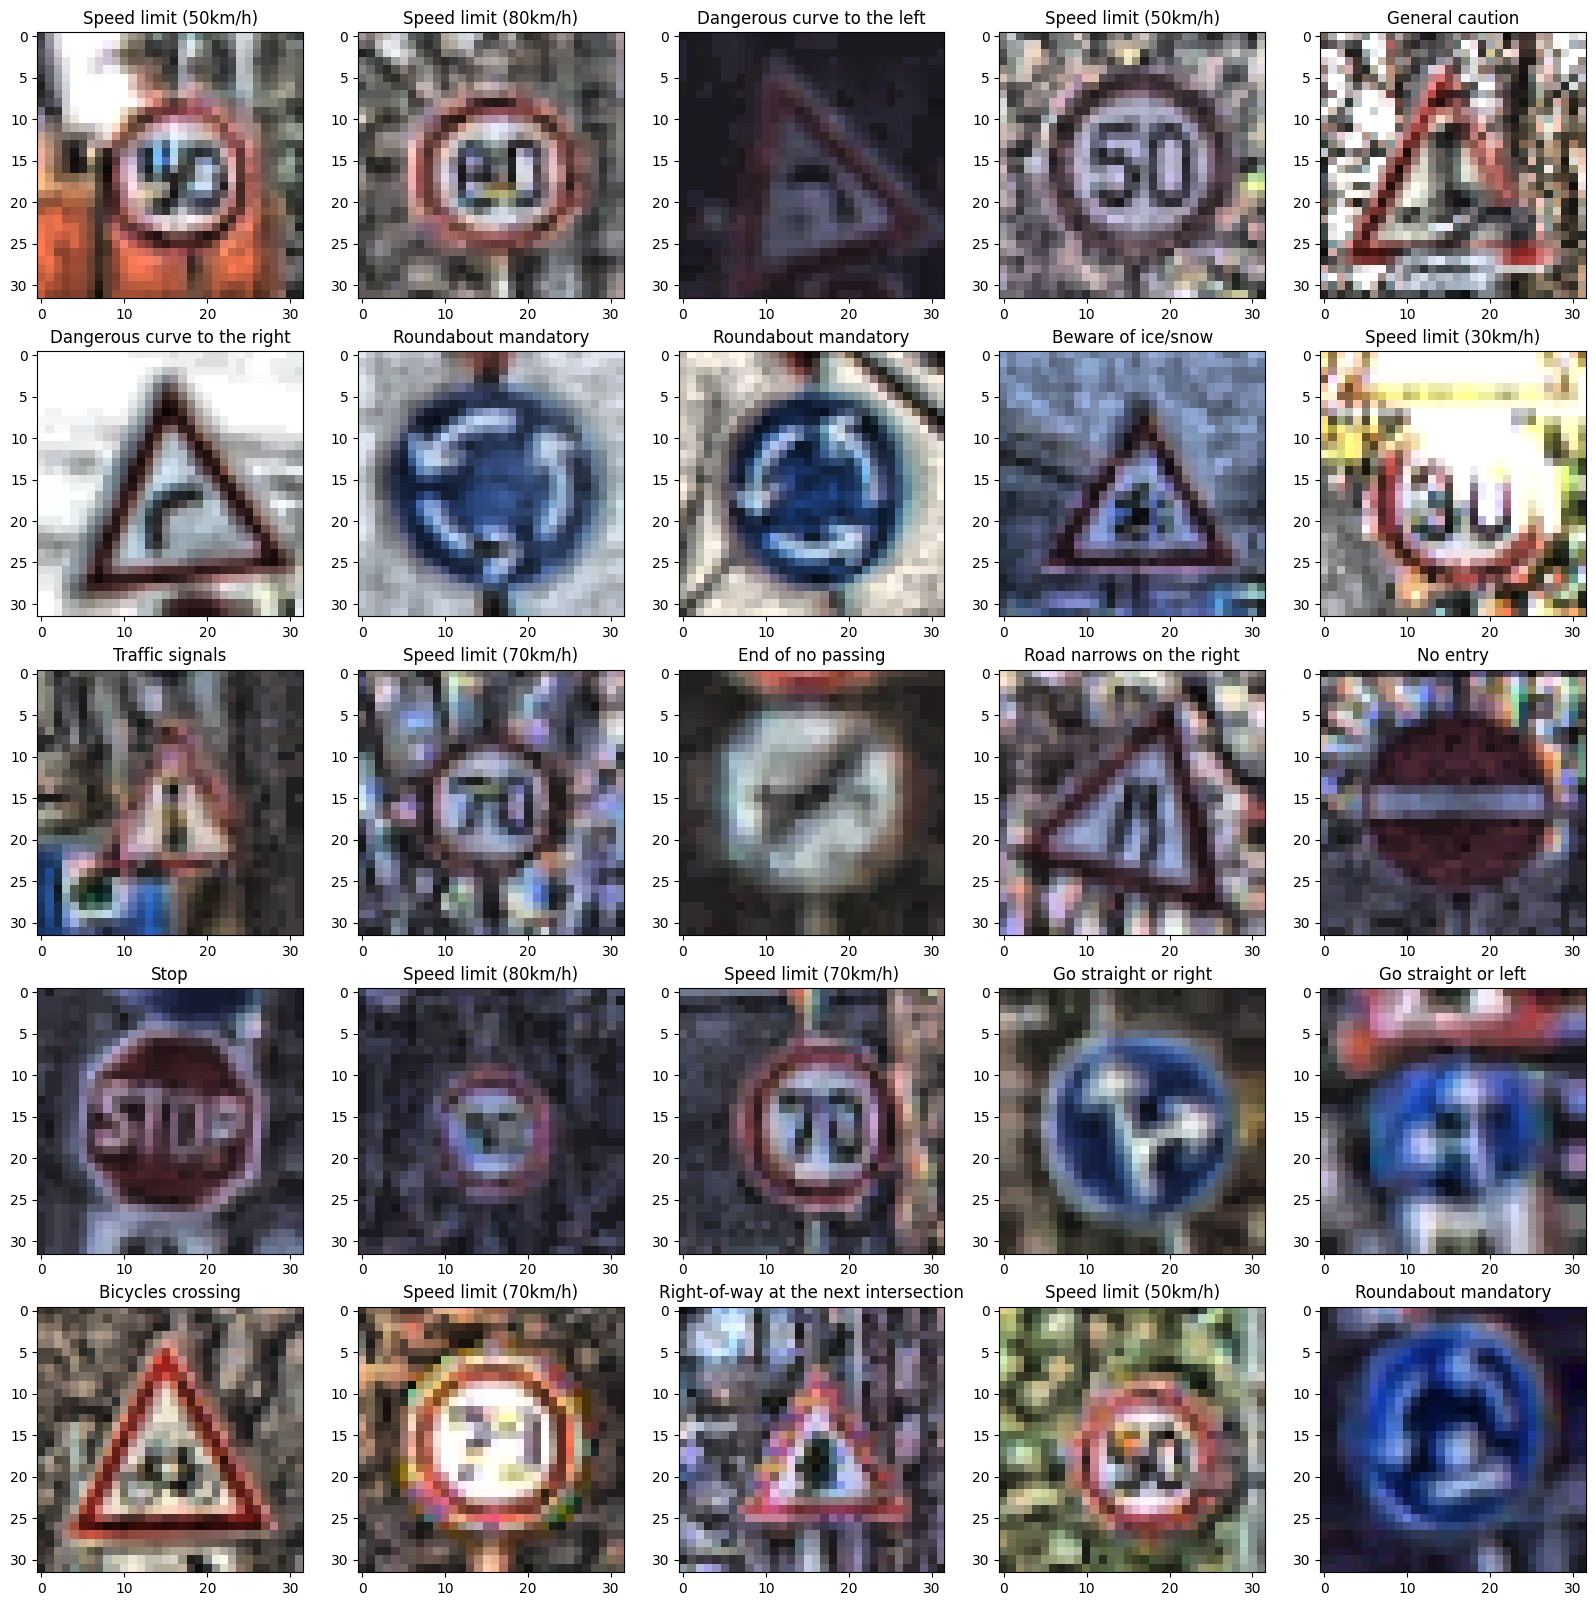

In [9]:
show_sample((5, 5), x_test, y_test, labels)

### Model

In [75]:
model = models.Sequential()

# 1st layer
model.add(layers.Conv2D(32, (4, 4), 
                        input_shape=(img_rows, img_cols, 3), 
                        kernel_initializer=initializers.GlorotNormal(),
                        kernel_regularizer=regularizers.L2(2e-4), 
                        activation=layers.PReLU(),
                        padding="valid")
         )
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(.1))

# 2nd layer
model.add(layers.Conv2D(32, (4, 4), 
                        kernel_initializer=initializers.GlorotNormal(),
                        kernel_regularizer=regularizers.L2(2e-4), 
                        activation=layers.PReLU(), 
                        padding="valid")
         )
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(.1))
model.add(layers.Flatten())

# 3rd layer
model.add(layers.Dense(2*output_size, 
                        kernel_initializer=initializers.GlorotNormal(),
                        kernel_regularizer=regularizers.L2(2e-4), 
                        activation=layers.PReLU())
         )
model.add(layers.BatchNormalization())
model.add(layers.Dropout(.1))


# 4th (output) layer
model.add(layers.Dense(output_size, activation='softmax'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(clipnorm=1, clipvalue=1),
              metrics=['acc']
             )

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 29, 29, 32)        28480     
                                                                 
 batch_normalization_12 (Bat  (None, 29, 29, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 32)        20288     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 5, 32)        

In [76]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size, 
    epochs=epochs,
    callbacks=[
        callbacks.ModelCheckpoint(os.path.join(models_dir, model_name), save_freq="epoch", verbose=0)
    ],
    validation_data=(x_valid, y_valid)
)

Train on 73000 samples, validate on 5000 samples
Epoch 1/5
73000/73000 [==============================] - ETA: 0s - loss: 0.4155 - acc: 0.9126

C:\Users\Kamil\miniconda3\envs\tensorflow\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


73000/73000 [==============================] - 49s 673us/sample - loss: 0.4155 - acc: 0.9126 - val_loss: 0.1036 - val_acc: 0.9838
Epoch 2/5
73000/73000 [==============================] - 128s 2ms/sample - loss: 0.1082 - acc: 0.9826 - val_loss: 0.0925 - val_acc: 0.9864
Epoch 3/5
 2688/73000 [>.............................] - ETA: 1:28 - loss: 0.0933 - acc: 0.9866

KeyboardInterrupt: 

In [48]:
model.save(os.path.join(models_dir, model_name))

In [ ]:
model = keras.models.load_model(os.path.join(models_dir, model_name))

### Results

In [49]:
def plot_comparison(value, val_value, metric):
    plt.clf()
    plt.figure(figsize=(25,5))
    epochs = range(len(value))
    plt.plot(epochs, value, 'bo', label=f"Training {metric}")
    plt.plot(epochs, val_value, 'b', label=f"Validation {metric}")
    plt.title(f"Comparison of Training and Validation {metric}")
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [50]:
def print_evaluation(model, x_test, y_test):
    loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    print(f"Test accuracy: {round(acc * 100, 2)}%")
    print(f"Test loss: {round(loss, 2)}")

In [51]:
def print_confusion_matrix(model, x_test, y_test, labels):
    y_pred = model.predict(x_test, verbose=0, batch_size=batch_size)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    
    cm = confusion_matrix(y_test, y_pred)
    ticks=np.linspace(0, output_size, num=output_size+1)
    plt.clf()
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='none')
    plt.colorbar()
    plt.xticks(ticks, fontsize=6)
    plt.xlabel("Predicted")
    plt.yticks(ticks, fontsize=6)
    plt.ylabel("True")
    plt.grid(True)
    plt.show()

In [52]:
print_evaluation(model, x_test, y_test)

Test accuracy: 98.05%
Test loss: 0.1


<Figure size 640x480 with 0 Axes>

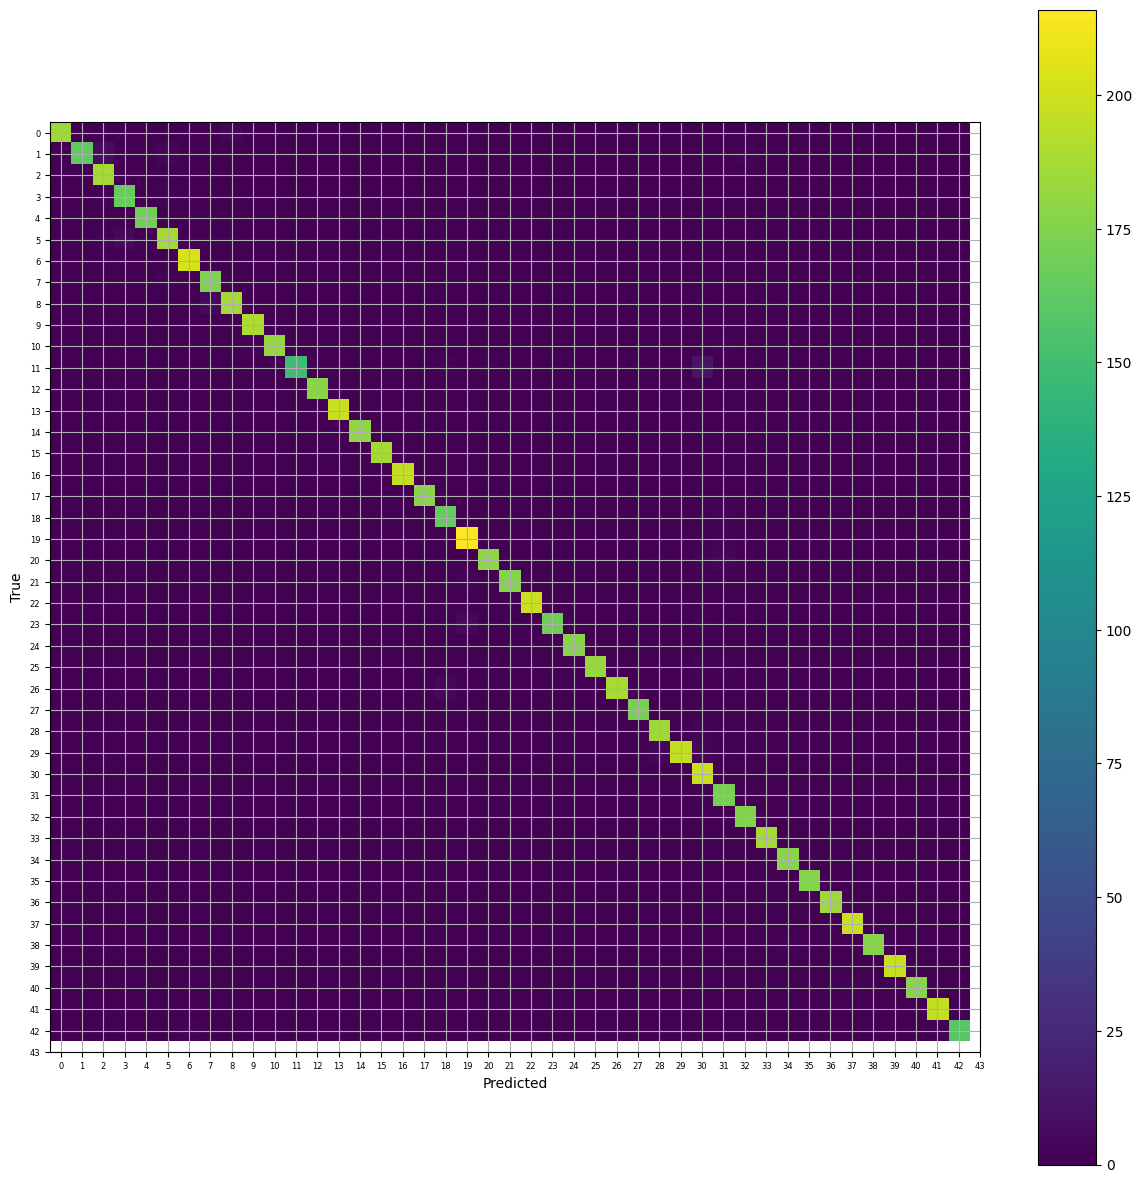

In [53]:
print_confusion_matrix(model, x_test, y_test, labels)

<Figure size 640x480 with 0 Axes>

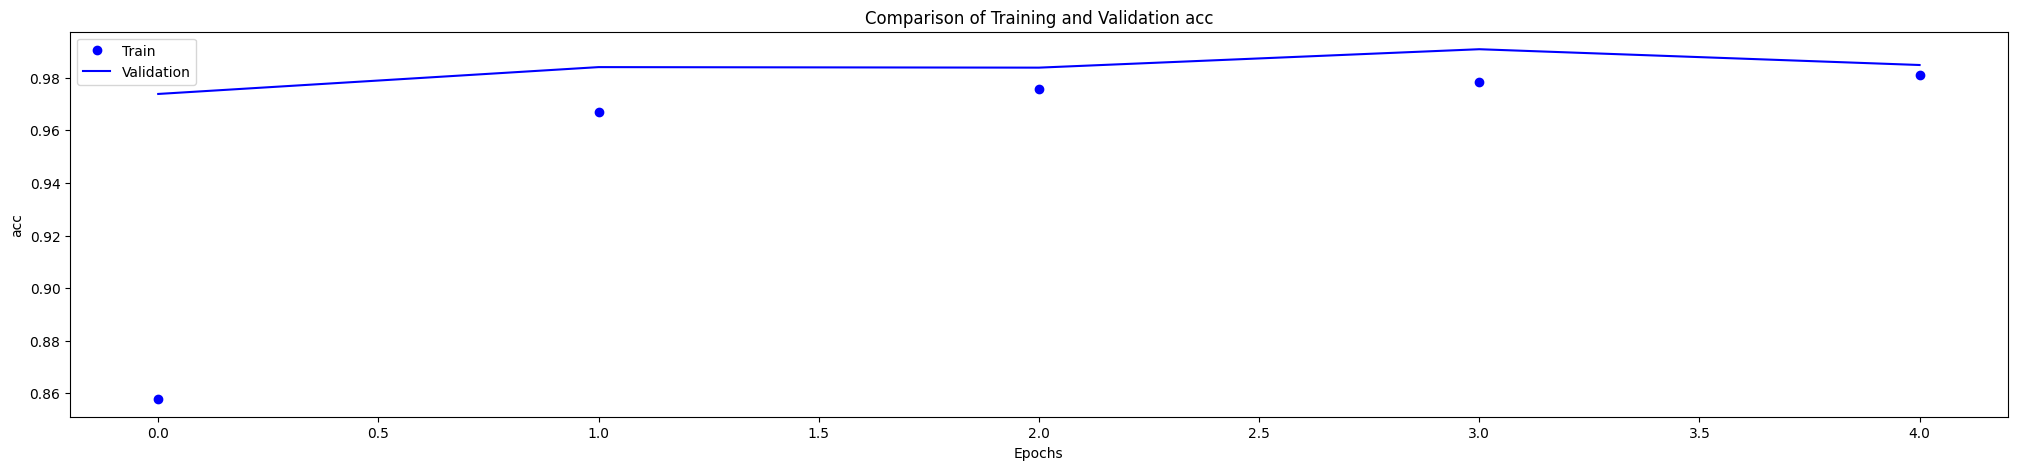

In [54]:
plot_comparison(history.history['acc'], history.history['val_acc'], "acc")

<Figure size 640x480 with 0 Axes>

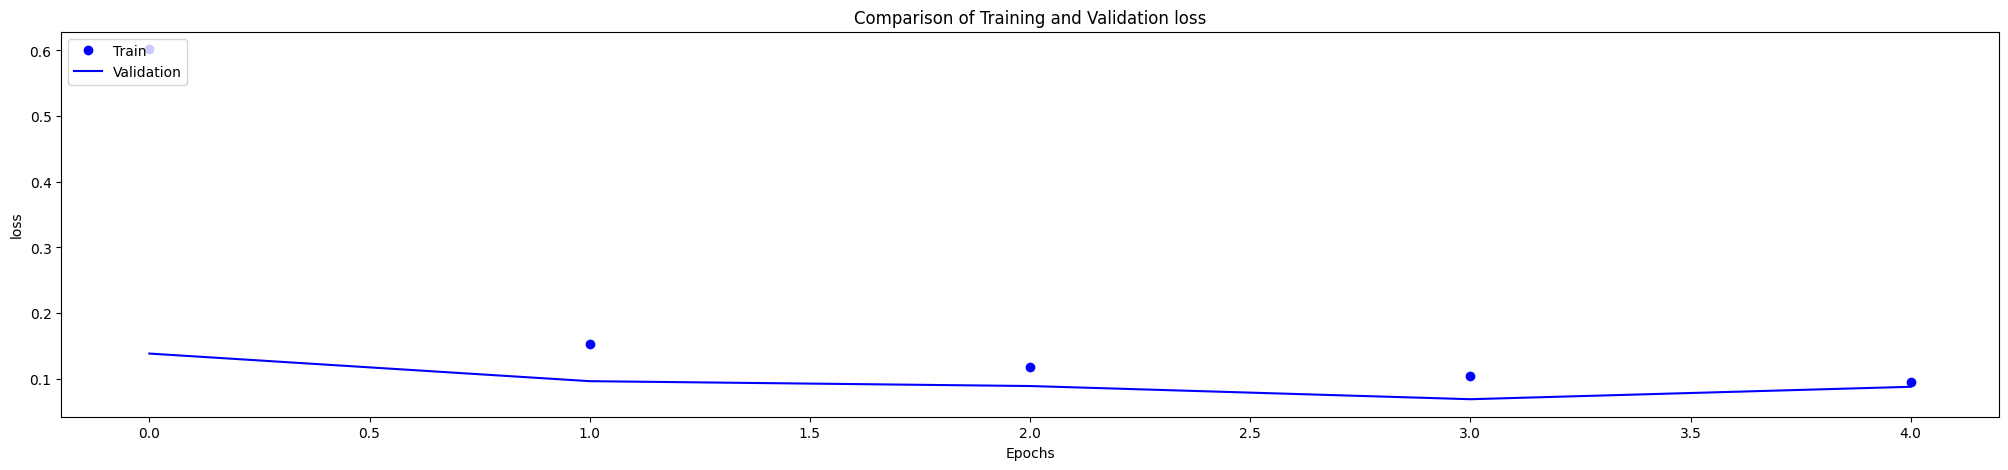

In [55]:
plot_comparison(history.history['loss'], history.history['val_loss'], "loss")

### Visualizing activation layers

In [56]:
def visualize_layers(model, img):
    layer_outputs = [layer.output for layer in model.layers if len(layer.output_shape) > 2 and "dropout" not in layer.name]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(img.reshape((1, img_rows, img_cols, 3)), verbose=0)

    layer_names = []
    images_per_row = 16
    for layer in layer_outputs:
        layer_names.append(layer.name)
        try:
            if layer.filters < images_per_row:
                images_per_row = layer.filters
        except:
            pass
        
    plt.figure(figsize=(1, 1))
    plt.title("Input image", fontsize=10)
    plt.imshow(img)

    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, size * images_per_row))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                if channel_image.std() != 0:
                    channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()

C:\Users\Kamil\miniconda3\envs\tensorflow\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


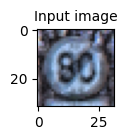

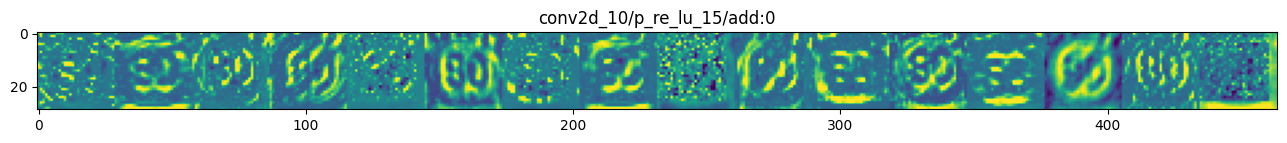

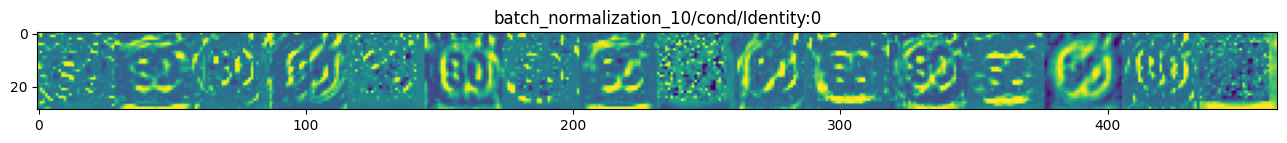

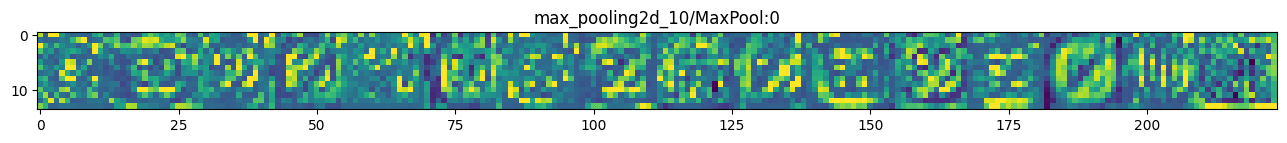

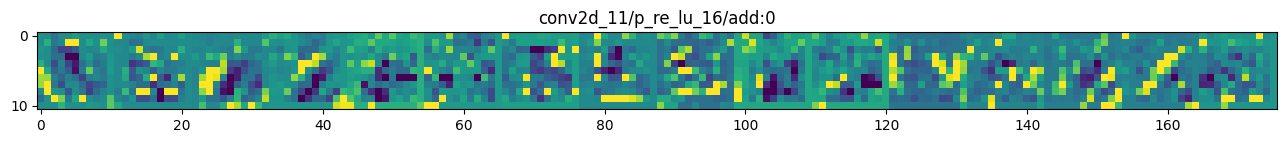

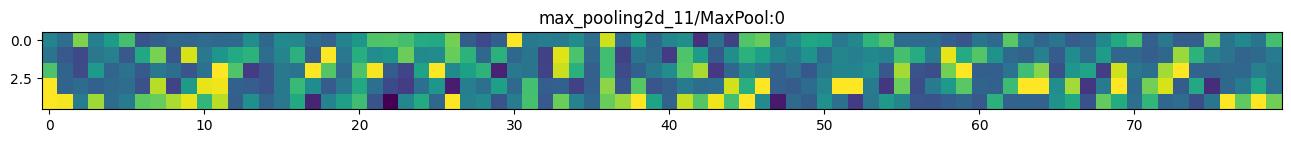

In [57]:
visualize_layers(model, x_test[2])

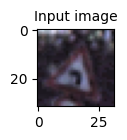

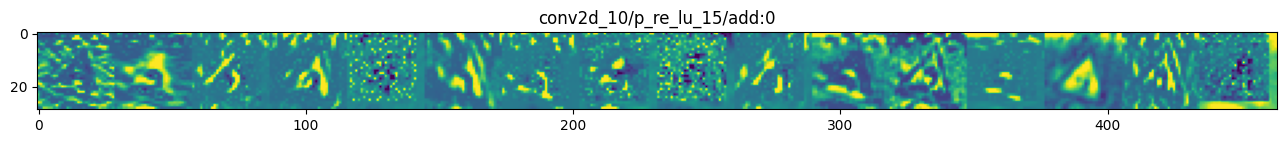

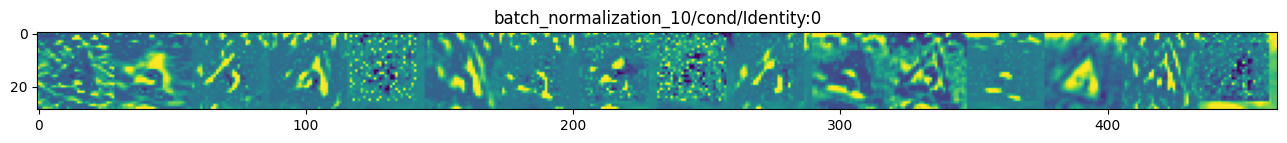

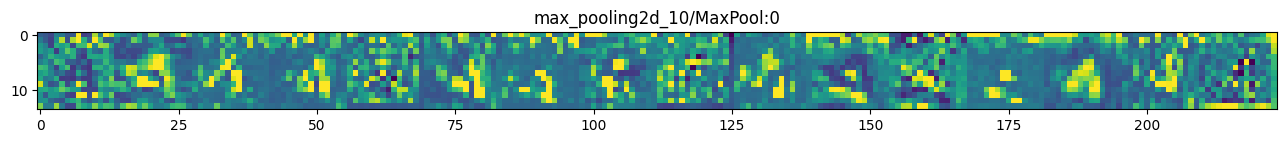

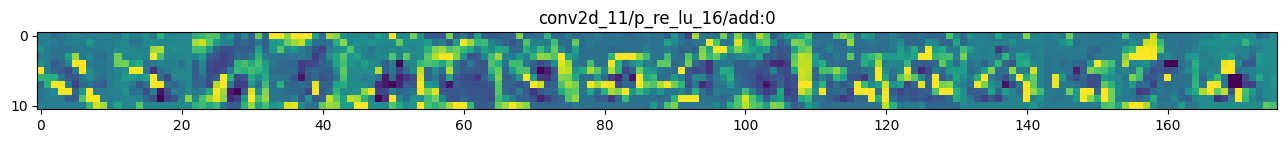

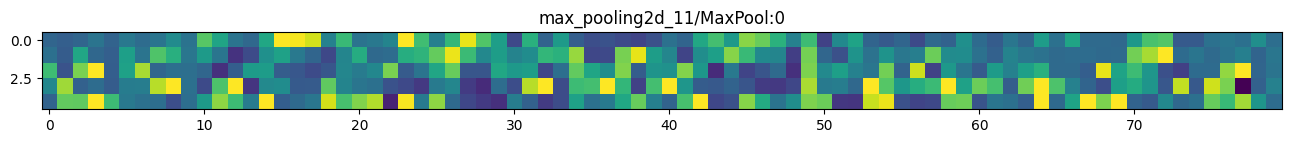

In [58]:
visualize_layers(model, x_test[142])

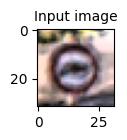

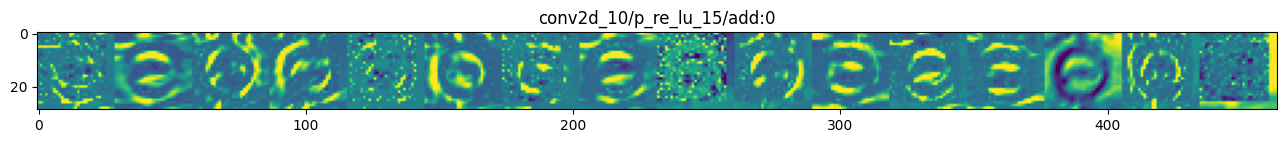

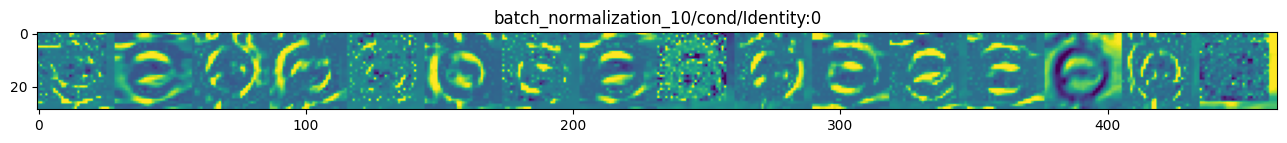

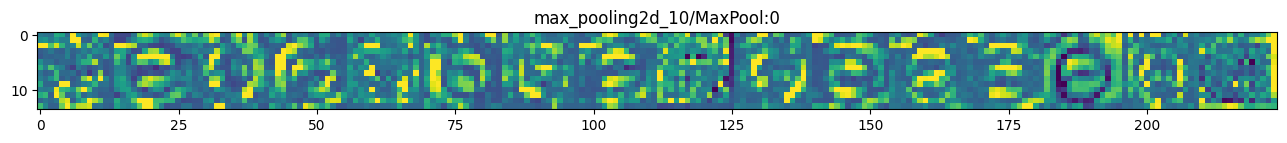

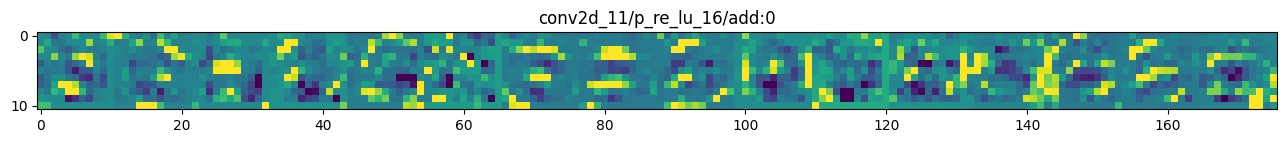

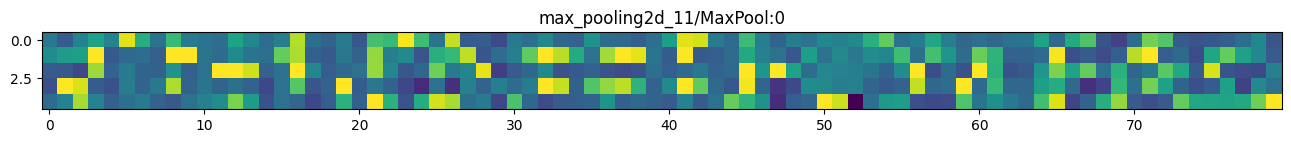

In [59]:
visualize_layers(model, x_test[36])

### Visualizing filters

In [60]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [61]:
def generate_pattern(model, layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 10 + 128.

    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

In [62]:
def rows_cols(value):
    assert value >= 1
    
    rows = 1
    cols = value
    for i in range(2, value//2+1):
        if value % i == 0:
            if np.abs(i - int(value / i)) < np.abs(rows - cols):
                rows = i
                cols = int(value / i)
    
    return rows, cols

In [63]:
def visualize_filters(model):
    margin = 3
    size = 32
    layers = [layer.name for layer in model.layers if len(layer.output_shape) > 2 and "conv" in layer.name]
    for layer_name in layers: 
        f_count = model.get_layer(layer_name).filters
        rows, cols = rows_cols(f_count)

        results = np.zeros((rows * size + (rows-1) * margin, cols * size + (cols-1) * margin, 3), dtype=np.uint8)
        for i in range(rows):
            for j in range(cols):
                filter_img = generate_pattern(model, layer_name, j + (i * cols), size=size)
                horizontal_start = i * size + i * margin
                horizontal_end = horizontal_start + size
                vertical_start = j * size + j * margin
                vertical_end = vertical_start + size
                results[horizontal_start : horizontal_end, vertical_start : vertical_end, : ] = filter_img

        print("Layer name: " + layer_name)
        plt.figure(figsize=(size / 2, size / 2))
        plt.imshow(results)
        plt.show()

Layer name: conv2d_10


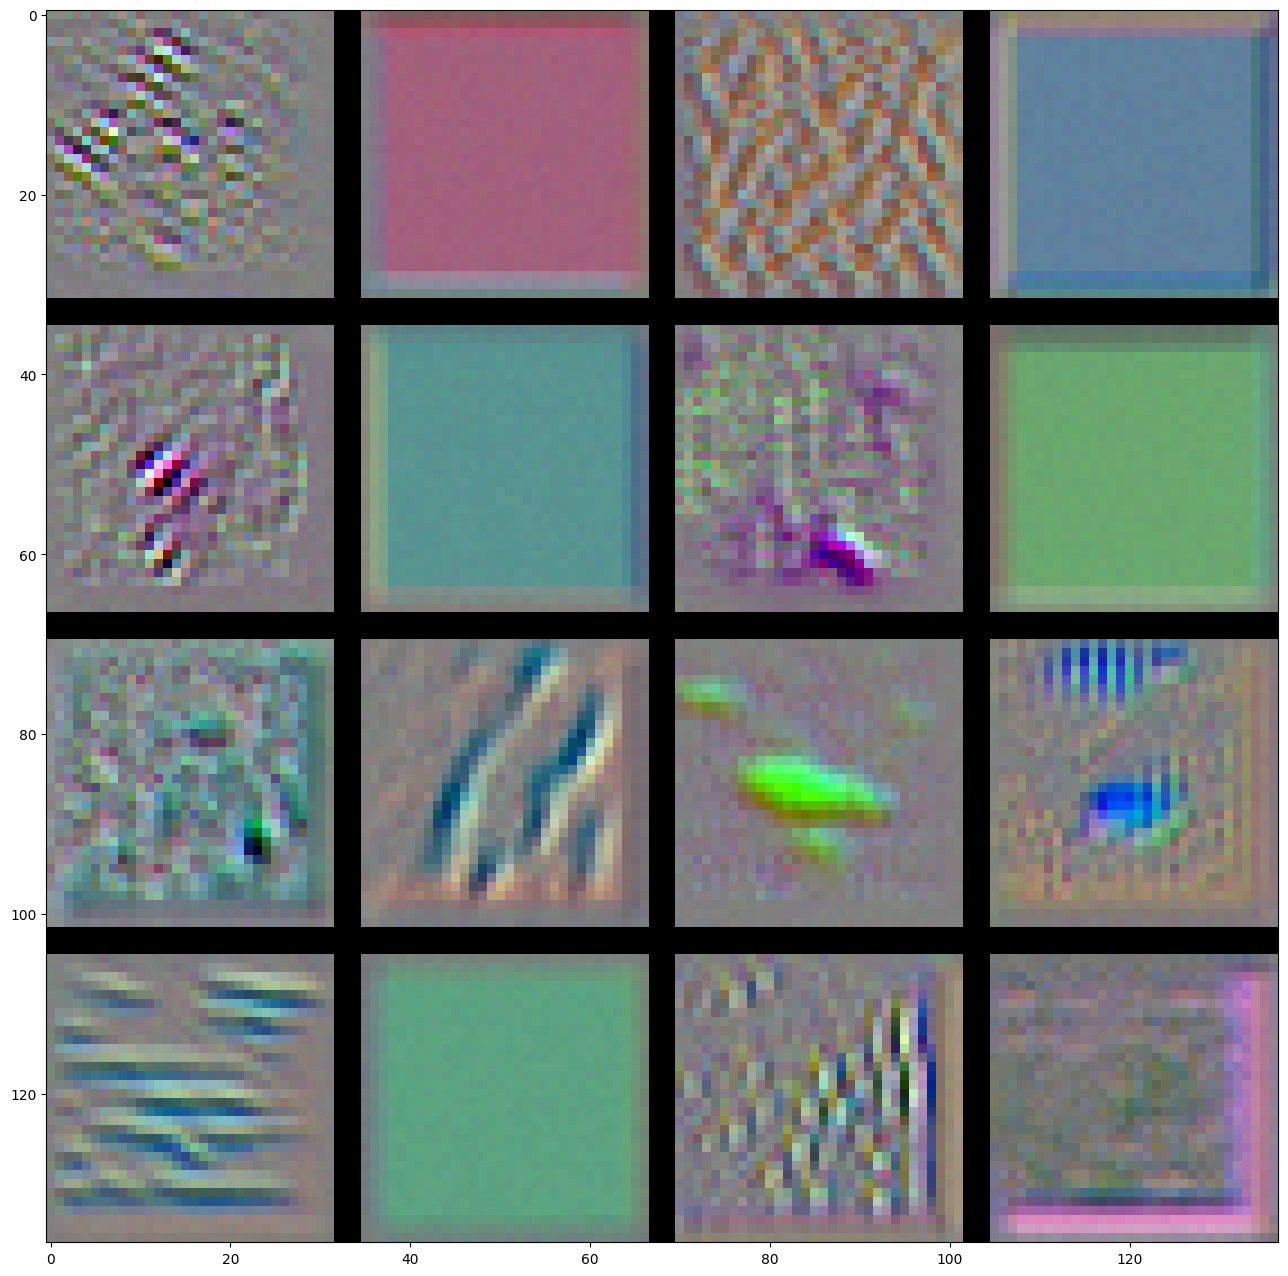

Layer name: conv2d_11


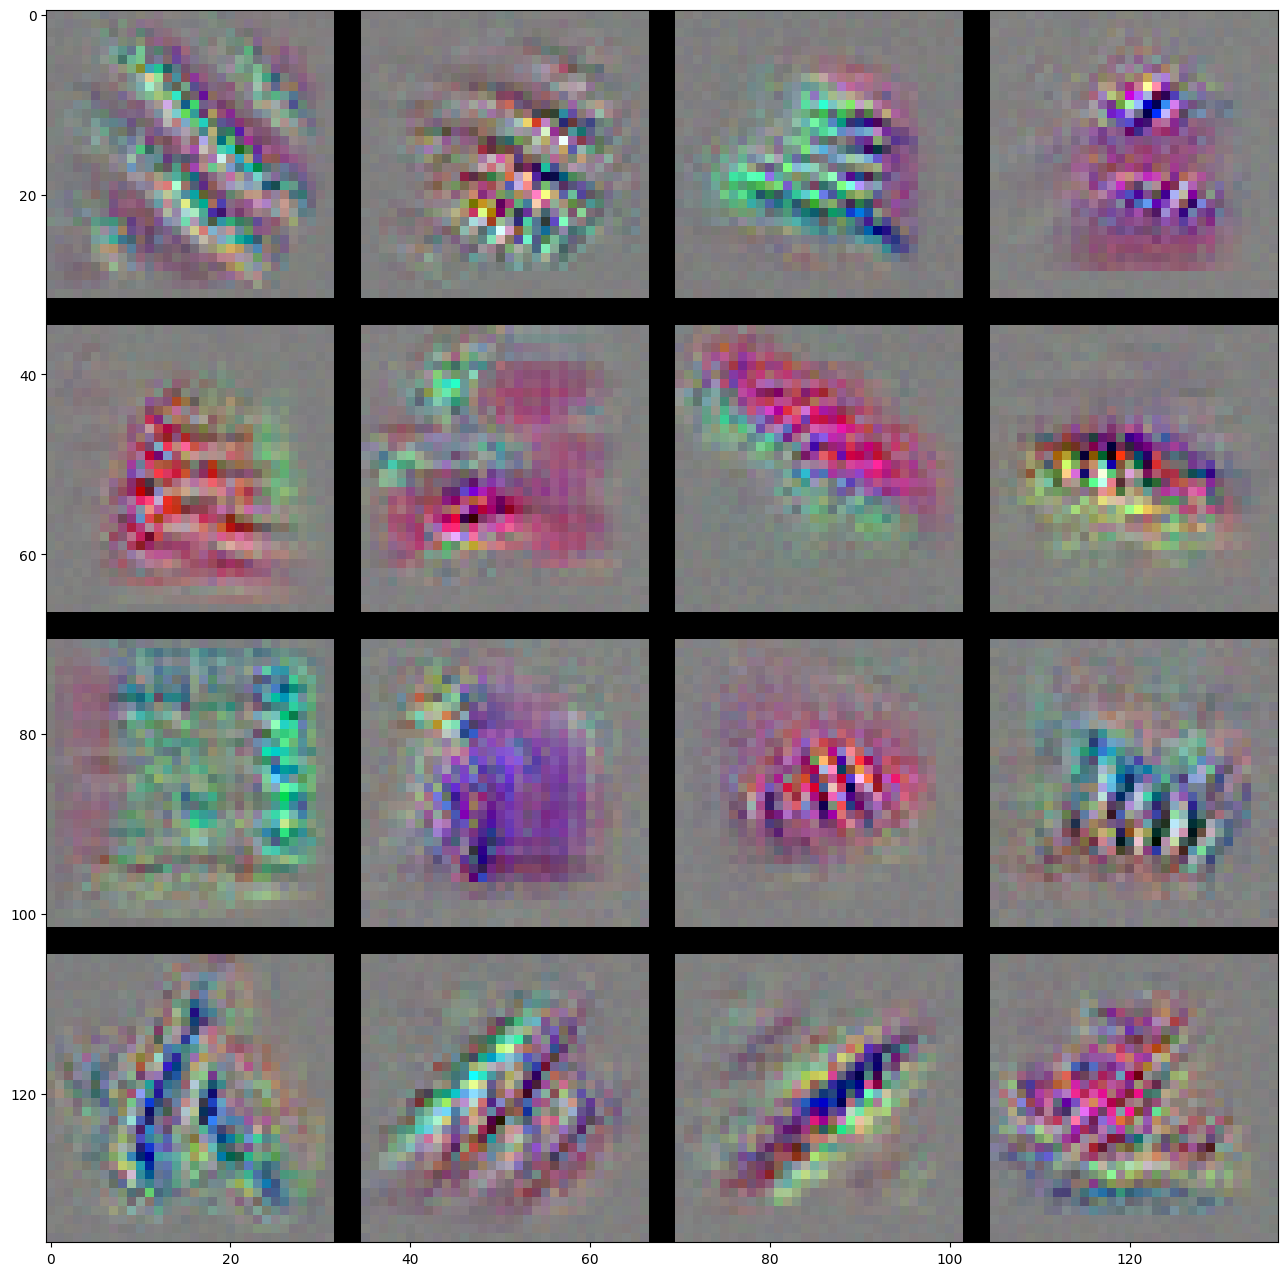

In [64]:
visualize_filters(model)

In [71]:
np.round(model.predict([[x_test[1]]])[0], 3)

array([0.002, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.996,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ], dtype=float32)

In [68]:
model.predict([[x_test[1]]])[0]

array([2.3833222e-03, 6.2399458e-06, 3.0095460e-08, 1.0553711e-05,
       2.3287353e-04, 9.5854939e-06, 3.4194576e-07, 1.3946778e-03,
       9.9584299e-01, 5.6868425e-06, 5.5368042e-07, 3.2774567e-06,
       1.5128553e-07, 1.0291788e-05, 3.2105543e-06, 5.4850184e-06,
       2.2138654e-05, 3.0426746e-09, 9.7080519e-06, 6.7477746e-10,
       7.6294995e-08, 5.3749798e-08, 3.4613554e-09, 5.5919389e-09,
       6.4631401e-08, 1.9874097e-08, 3.8938321e-08, 1.4754632e-10,
       7.2029417e-07, 3.1885680e-05, 6.5339609e-09, 1.8754039e-06,
       9.7666157e-07, 9.6508052e-07, 2.0174956e-07, 9.1455295e-06,
       1.9664864e-08, 6.6364767e-09, 7.7699383e-08, 6.4609218e-08,
       1.2718265e-05, 6.5669170e-10, 1.1922286e-09], dtype=float32)

In [72]:
labels[8]

'Speed limit (120km/h)'

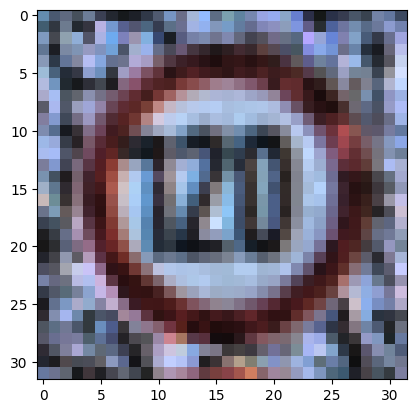

In [73]:
plt.imshow(x_test[1])